### Import the necessary libraries

In [14]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from segmentation_models import Unet
from segmentation_models.backbones import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
import pandas as pd

from keras.layers import Input, Conv2D, Reshape
from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.utils import Sequence
from keras.backend import epsilon

### Load the training data from train.csv file

In [12]:
df = pd.read_csv('train_labels.csv')
df.head(5)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


### Print the shape of the train dataset

In [13]:
df.shape

(173, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [15]:
IMAGE_SIZE = 128

### With the help of csvr.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [25]:
paths = []
coords = np.zeros((173, 4))

for index, row in df.iterrows():
    paths.append('images-r9/'+row.filename)
    x0 = row.xmin
    x1 = row.xmax
    y0 = row.ymin
    y1 = row.ymax
    image_width = row.width
    image_height = row.height
    coords[index, 0] = x0 * IMAGE_SIZE / image_width 
    coords[index, 1] = y0 * IMAGE_SIZE / image_height 
    coords[index, 2] = (x1 - x0) * IMAGE_SIZE / image_width 
    coords[index, 3] = (y1 - y0) * IMAGE_SIZE / image_height

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [26]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(paths):
    try:
        img = Image.open(f) 
    except:
        print(i)
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) 
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [30]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=1.0) 

for layer in model.layers:
    layer.trainable = False

x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
x = Reshape((4,))(x)

model = Model(inputs=model.input, outputs=x)

In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
__________

### Define a custom loss function IoU which calculates Intersection Over Union

In [32]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection


    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [34]:
import tensorflow as tf
gt = coords
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) 

model.fit(batch_images,gt,
            epochs=30,batch_size = 32,
            verbose=1)

Epoch 1/30
173/173 [==============================] - 30s 173ms/step - loss: 2870.2473 - IoU: 0.0808
Epoch 2/30
173/173 [==============================] - 28s 161ms/step - loss: 688.8249 - IoU: 0.4309
Epoch 3/30
173/173 [==============================] - 29s 169ms/step - loss: 648.9450 - IoU: 0.5318
Epoch 4/30
173/173 [==============================] - 28s 162ms/step - loss: 573.6354 - IoU: 0.5364
Epoch 5/30
173/173 [==============================] - 28s 162ms/step - loss: 342.2617 - IoU: 0.5982
Epoch 6/30
173/173 [==============================] - 28s 165ms/step - loss: 280.1857 - IoU: 0.5722
Epoch 7/30
173/173 [==============================] - 28s 159ms/step - loss: 247.9412 - IoU: 0.5975
Epoch 8/30
173/173 [==============================] - 28s 162ms/step - loss: 195.4494 - IoU: 0.6584
Epoch 9/30
173/173 [==============================] - 26s 153ms/step - loss: 166.5483 - IoU: 0.6968
Epoch 10/30
173/173 [==============================] - 26s 148ms/step - loss: 147.1541 - IoU: 0.711

### Pick a test image from the given data

In [35]:
import cv2
filename = paths[5]
unscaled = cv2.imread(filename)

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [36]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) 
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [37]:
region = model.predict(x=np.array([feat_scaled]))[0]

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

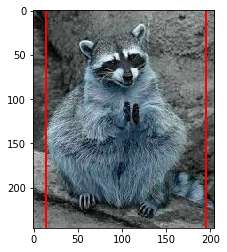

In [38]:
x0 = int(region[0] * image_width / IMAGE_SIZE)
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

fig,ax = plt.subplots(1)

ax.imshow(unscaled)

rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='r', facecolor='none')

ax.add_patch(rect)

plt.show()

## Problem 2 : Time Series Analysis using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temperature values to "Temperature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temperature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

### Import required libraries

In [1]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers
import pandas as pd 
import tensorflow as tf
import numpy as np

D:\Users\irutsil\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Mount google drive

### Load the  data file

In [13]:
df = pd.read_csv('daily-minimum-temperatures-in-me.csv',index_col='Date')
print(df.head(5))

            Daily_min_temp
Date                      
01/01/1981            20.7
02/01/1981            17.9
03/01/1981            18.8
04/01/1981            14.6
05/01/1981            15.8


### Plot the data

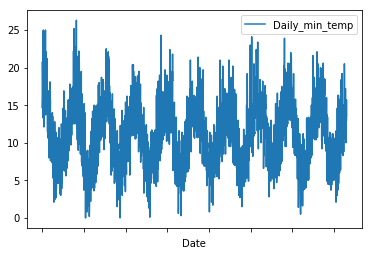

In [14]:
df.plot()

### Check for null values and treat them

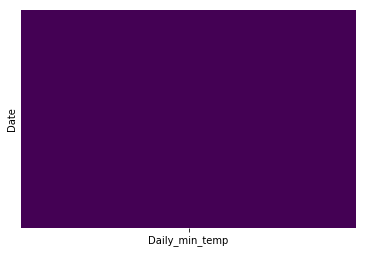

In [16]:
import seaborn as sns
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

#### Drop null values (if any)

In [18]:
df.isnull().sum()

Daily_min_temp    0
dtype: int64

### Get the representation of the distribution of data in the form of histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000F932978>]],
      dtype=object)

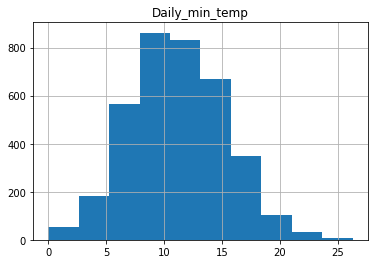

In [19]:
df.hist(bins=10)

### Check the maximum and minimum values

In [21]:
print('Minimum temp: ',min(df.Daily_min_temp))
print('Maximum temp: ',max(df.Daily_min_temp))

Minimum temp:  0.0
Maximum temp:  26.3


### Normalize the data

In [23]:
dataset = df.astype('float32')

In [24]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset)

### Check the maximum and minimum values of scaled data

In [25]:
print('Min', np.min(scaled))
print('Max', np.max(scaled))

Min 0.0
Max 1.0


### Split data into Training and Testing set 
<u>Note</u> The train and test data has to be sequential. Keep the first 70% of data in training and the bottom 30% in test data 

In [26]:
train_size = int(len(scaled) * 0.70)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2555
test: 1095


## Create the sequential data
Map the temperature at a particular time t to the temperature at time t+n, where n is any number you define.

For example: to map temperatures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [27]:
def create_dataset(dataset, look_back=1):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        print(i)
        print('X {} to {}'.format(i, i+look_back))
        print(a)
        print('Y {}'.format(i + look_back))
        print(dataset[i + look_back, 0])
        dataset[i + look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

### Use function to get training and test set

In [28]:
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

2555 1
0
X 0 to 1
[0.7870723]
Y 1
0.6806083702582986
1
X 1 to 2
[0.68060837]
Y 2
0.7148288890658444
2
X 2 to 3
[0.71482889]
Y 3
0.5551331104563756
3
X 3 to 4
[0.55513311]
Y 4
0.6007604809535642
4
X 4 to 5
[0.60076048]
Y 5
0.6007604809535642
5
X 5 to 6
[0.60076048]
Y 6
0.6007604809535642
6
X 6 to 7
[0.60076048]
Y 7
0.6615969628626882
7
X 7 to 8
[0.66159696]
Y 8
0.8288973334395067
8
X 8 to 9
[0.82889733]
Y 9
0.7604562958244149
9
X 9 to 10
[0.7604563]
Y 10
0.6159696286268815
10
X 10 to 11
[0.61596963]
Y 11
0.5057034439755123
11
X 11 to 12
[0.50570344]
Y 12
0.6349810360224919
12
X 12 to 13
[0.63498104]
Y 13
0.817490518011246
13
X 13 to 14
[0.81749052]
Y 14
0.9505703697805186
14
X 14 to 15
[0.95057037]
Y 15
0.7870722951873749
15
X 15 to 16
[0.7870723]
Y 16
0.7832699992037001
16
X 16 to 17
[0.78327]
Y 17
0.9429657778131689
17
X 17 to 18
[0.94296578]
Y 18
0.6730038508137127
18
X 18 to 19
[0.67300385]
Y 19
0.5893536292639215
19
X 19 to 20
[0.58935363]
Y 20
0.6920152582093231
20
X 20 to 21
[0.6

X 246 to 247
[0.36501904]
Y 247
0.3231939257253763
247
X 247 to 248
[0.32319393]
Y 248
0.2851711109341556
248
X 248 to 249
[0.28517111]
Y 249
0.42585551840939595
249
X 249 to 250
[0.42585552]
Y 250
0.5551331104563756
250
X 250 to 251
[0.55513311]
Y 251
0.4448669258050063
251
X 251 to 252
[0.44486693]
Y 252
0.2965779626237982
252
X 252 to 253
[0.29657796]
Y 253
0.46768062918429154
253
X 253 to 254
[0.46768063]
Y 254
0.38403044389588226
254
X 254 to 255
[0.38403044]
Y 255
0.43726237009903857
255
X 255 to 256
[0.43726237]
Y 256
0.2775665552281878
256
X 256 to 257
[0.27756656]
Y 257
0.41444866671975333
257
X 257 to 258
[0.41444867]
Y 258
0.5361217030607652
258
X 258 to 259
[0.5361217]
Y 259
0.4068441110137856
259
X 259 to 260
[0.40684411]
Y 260
0.6425855554670779
260
X 260 to 261
[0.64258556]
Y 261
0.3992395553078178
261
X 261 to 262
[0.39923956]
Y 262
0.24714829614293482
262
X 262 to 263
[0.2471483]
Y 263
0.4182509627034282
263
X 263 to 264
[0.41825096]
Y 264
0.23954374043696708
264
X 264

X 446 to 447
[0.59315593]
Y 447
0.5019011479918374
447
X 447 to 448
[0.50190115]
Y 448
0.5513308144727008
448
X 448 to 449
[0.55133081]
Y 449
0.638783259483403
449
X 449 to 450
[0.63878326]
Y 450
0.6539924434181024
450
X 450 to 451
[0.65399244]
Y 451
0.5095057036978052
451
X 451 to 452
[0.5095057]
Y 452
0.5399239627830582
452
X 452 to 453
[0.53992396]
Y 453
0.543726258766733
453
X 453 to 454
[0.54372626]
Y 454
0.3878327036181752
454
X 454 to 455
[0.3878327]
Y 455
0.395437259324143
455
X 455 to 456
[0.39543726]
Y 456
0.46768062918429154
456
X 456 to 457
[0.46768063]
Y 457
0.4524714815109741
457
X 457 to 458
[0.45247148]
Y 458
0.42585551840939595
458
X 458 to 459
[0.42585552]
Y 459
0.3231939257253763
459
X 459 to 460
[0.32319393]
Y 460
0.4562737774946489
460
X 460 to 461
[0.45627378]
Y 461
0.47148288890658446
461
X 461 to 462
[0.47148289]
Y 462
0.4904942963021948
462
X 462 to 463
[0.4904943]
Y 463
0.38403044389588226
463
X 463 to 464
[0.38403044]
Y 464
0.5703422218683112
464
X 464 to 465

646
X 646 to 647
[0.32699622]
Y 647
0.3574144445329222
647
X 647 to 648
[0.35741444]
Y 648
0.21673003705768185
648
X 648 to 649
[0.21673004]
Y 649
0.41444866671975333
649
X 649 to 650
[0.41444867]
Y 650
0.4980988882695445
650
X 650 to 651
[0.49809889]
Y 651
0.395437259324143
651
X 651 to 652
[0.39543726]
Y 652
0.3117870740357337
652
X 652 to 653
[0.31178707]
Y 653
0.3726235922062397
653
X 653 to 654
[0.37262359]
Y 654
0.2851711109341556
654
X 654 to 655
[0.28517111]
Y 655
0.2205323330413567
655
X 655 to 656
[0.22053233]
Y 656
0.3726235922062397
656
X 656 to 657
[0.37262359]
Y 657
0.3003802404767821
657
X 657 to 658
[0.30038024]
Y 658
0.3307984814313441
658
X 658 to 659
[0.33079848]
Y 659
0.38022814791220744
659
X 659 to 660
[0.38022815]
Y 660
0.40304185129149267
660
X 660 to 661
[0.40304185]
Y 661
0.30418251832976595
661
X 661 to 662
[0.30418252]
Y 662
0.3878327036181752
662
X 662 to 663
[0.3878327]
Y 663
0.574144517851986
663
X 663 to 664
[0.57414452]
Y 664
0.5285171110934156
664
X 66

[0.31558937]
Y 920
0.09125475912506797
920
X 920 to 921
[0.09125476]
Y 921
0.18631179610311985
921
X 921 to 922
[0.1863118]
Y 922
0.2243346108943406
922
X 922 to 923
[0.22433461]
Y 923
0.2547528518489026
923
X 923 to 924
[0.25475285]
Y 924
0.3193916297417015
924
X 924 to 925
[0.31939163]
Y 925
0.24714829614293482
925
X 925 to 926
[0.2471483]
Y 926
0.3003802404767821
926
X 926 to 927
[0.30038024]
Y 927
0.15589353701786685
927
X 927 to 928
[0.15589354]
Y 928
0.2053232034987302
928
X 928 to 929
[0.2053232]
Y 929
0.2851711109341556
929
X 929 to 930
[0.28517111]
Y 930
0.1482889813118991
930
X 930 to 931
[0.14828898]
Y 931
0.09505703697805186
931
X 931 to 932
[0.09505704]
Y 932
0.20152092564574633
932
X 932 to 933
[0.20152093]
Y 933
0.2509505739959187
933
X 933 to 934
[0.25095057]
Y 934
0.0
934
X 934 to 935
[0.]
Y 935
0.026615969900587247
935
X 935 to 936
[0.02661597]
Y 936
0.28897338878713946
936
X 936 to 937
[0.28897339]
Y 937
0.46768062918429154
937
X 937 to 938
[0.46768063]
Y 938
0.34980

[0.74144489]
Y 1096
0.6501901474344275
1096
X 1096 to 1097
[0.65019015]
Y 1097
0.6501901474344275
1097
X 1097 to 1098
[0.65019015]
Y 1098
0.4562737774946489
1098
X 1098 to 1099
[0.45627378]
Y 1099
0.4182509627034282
1099
X 1099 to 1100
[0.41825096]
Y 1100
0.6197718520877926
1100
X 1100 to 1101
[0.61977185]
Y 1101
0.6121673326432068
1101
X 1101 to 1102
[0.61216733]
Y 1102
0.49429659228586964
1102
X 1102 to 1103
[0.49429659]
Y 1103
0.5095057036978052
1103
X 1103 to 1104
[0.5095057]
Y 1104
0.5779467775742789
1104
X 1104 to 1105
[0.57794678]
Y 1105
0.4752851848902593
1105
X 1105 to 1106
[0.47528518]
Y 1106
0.543726258766733
1106
X 1106 to 1107
[0.54372626]
Y 1107
0.6273764440551423
1107
X 1107 to 1108
[0.62737644]
Y 1108
0.7072243696212586
1108
X 1108 to 1109
[0.70722437]
Y 1109
0.6844106662419733
1109
X 1109 to 1110
[0.68441067]
Y 1110
0.6920152582093231
1110
X 1110 to 1111
[0.69201526]
Y 1111
0.4334600741153637
1111
X 1111 to 1112
[0.43346007]
Y 1112
0.4524714815109741
1112
X 1112 to 111

0.3307984814313441
1246
X 1246 to 1247
[0.33079848]
Y 1247
0.34220533312098667
1247
X 1247 to 1248
[0.34220533]
Y 1248
0.4106464069974604
1248
X 1248 to 1249
[0.41064641]
Y 1249
0.47148288890658446
1249
X 1249 to 1250
[0.47148289]
Y 1250
0.273764259244513
1250
X 1250 to 1251
[0.27376426]
Y 1251
0.273764259244513
1251
X 1251 to 1252
[0.27376426]
Y 1252
0.42205325868710303
1252
X 1252 to 1253
[0.42205326]
Y 1253
0.3536121848106293
1253
X 1253 to 1254
[0.35361218]
Y 1254
0.38403044389588226
1254
X 1254 to 1255
[0.38403044]
Y 1255
0.1482889813118991
1255
X 1255 to 1256
[0.14828898]
Y 1256
0.19011407395610372
1256
X 1256 to 1257
[0.19011407]
Y 1257
0.3117870740357337
1257
X 1257 to 1258
[0.31178707]
Y 1258
0.10646387960234899
1258
X 1258 to 1259
[0.10646388]
Y 1259
0.1634981108545256
1259
X 1259 to 1260
[0.16349811]
Y 1260
0.30798481431344077
1260
X 1260 to 1261
[0.30798481]
Y 1261
0.42205325868710303
1261
X 1261 to 1262
[0.42205326]
Y 1262
0.1787072222664611
1262
X 1262 to 1263
[0.17870722

Y 1446
0.638783259483403
1446
X 1446 to 1447
[0.63878326]
Y 1447
0.46007607347832374
1447
X 1447 to 1448
[0.46007607]
Y 1448
0.42965781439307077
1448
X 1448 to 1449
[0.42965781]
Y 1449
0.395437259324143
1449
X 1449 to 1450
[0.39543726]
Y 1450
0.5399239627830582
1450
X 1450 to 1451
[0.53992396]
Y 1451
0.4334600741153637
1451
X 1451 to 1452
[0.43346007]
Y 1452
0.5209125553874479
1452
X 1452 to 1453
[0.52091256]
Y 1453
0.6273764440551423
1453
X 1453 to 1454
[0.62737644]
Y 1454
0.4866920365799019
1454
X 1454 to 1455
[0.48669204]
Y 1455
0.46387833320061667
1455
X 1455 to 1456
[0.46387833]
Y 1456
0.4562737774946489
1456
X 1456 to 1457
[0.45627378]
Y 1457
0.47908748087393416
1457
X 1457 to 1458
[0.47908748]
Y 1458
0.6083650366595319
1458
X 1458 to 1459
[0.60836504]
Y 1459
0.6235741480714674
1459
X 1459 to 1460
[0.62357415]
Y 1460
0.5057034439755123
1460
X 1460 to 1461
[0.50570344]
Y 1461
0.5779467775742789
1461
X 1461 to 1462
[0.57794678]
Y 1462
0.4980988882695445
1462
X 1462 to 1463
[0.49809

[0.31939163]
Y 1663
0.011406844890633497
1663
X 1663 to 1664
[0.01140684]
Y 1664
0.011406844890633497
1664
X 1664 to 1665
[0.01140684]
Y 1665
0.07984790743542537
1665
X 1665 to 1666
[0.07984791]
Y 1666
0.3231939257253763
1666
X 1666 to 1667
[0.32319393]
Y 1667
0.053231939801174494
1667
X 1667 to 1668
[0.05323194]
Y 1668
0.15589353701786685
1668
X 1668 to 1669
[0.15589354]
Y 1669
0.39163499960185005
1669
X 1669 to 1670
[0.391635]
Y 1670
0.2509505739959187
1670
X 1670 to 1671
[0.25095057]
Y 1671
0.23193916660030833
1671
X 1671 to 1672
[0.23193917]
Y 1672
0.26615970353854523
1672
X 1672 to 1673
[0.2661597]
Y 1673
0.1939163518090876
1673
X 1673 to 1674
[0.19391635]
Y 1674
0.23954374043696708
1674
X 1674 to 1675
[0.23954374]
Y 1675
0.2623574256855613
1675
X 1675 to 1676
[0.26235743]
Y 1676
0.4334600741153637
1676
X 1676 to 1677
[0.43346007]
Y 1677
0.395437259324143
1677
X 1677 to 1678
[0.39543726]
Y 1678
0.39163499960185005
1678
X 1678 to 1679
[0.391635]
Y 1679
0.34980988882695446
1679
X 16

Y 1940
0.31558937001940857
1940
X 1940 to 1941
[0.31558937]
Y 1941
0.3992395553078178
1941
X 1941 to 1942
[0.39923956]
Y 1942
0.34220533312098667
1942
X 1942 to 1943
[0.34220533]
Y 1943
0.2623574256855613
1943
X 1943 to 1944
[0.26235743]
Y 1944
0.3574144445329222
1944
X 1944 to 1945
[0.35741444]
Y 1945
0.42205325868710303
1945
X 1945 to 1946
[0.42205326]
Y 1946
0.34600762910466154
1946
X 1946 to 1947
[0.34600763]
Y 1947
0.29277566664012333
1947
X 1947 to 1948
[0.29277567]
Y 1948
0.38022814791220744
1948
X 1948 to 1949
[0.38022815]
Y 1949
0.395437259324143
1949
X 1949 to 1950
[0.39543726]
Y 1950
0.30418251832976595
1950
X 1950 to 1951
[0.30418252]
Y 1951
0.3726235922062397
1951
X 1951 to 1952
[0.37262359]
Y 1952
0.47148288890658446
1952
X 1952 to 1953
[0.47148289]
Y 1953
0.4904942963021948
1953
X 1953 to 1954
[0.4904943]
Y 1954
0.46768062918429154
1954
X 1954 to 1955
[0.46768063]
Y 1955
0.2623574256855613
1955
X 1955 to 1956
[0.26235743]
Y 1956
0.3992395553078178
1956
X 1956 to 1957
[0.

[0.58174907]
Y 2146
0.39163499960185005
2146
X 2146 to 2147
[0.391635]
Y 2147
0.4068441110137856
2147
X 2147 to 2148
[0.40684411]
Y 2148
0.3992395553078178
2148
X 2148 to 2149
[0.39923956]
Y 2149
0.33840303713731185
2149
X 2149 to 2150
[0.33840304]
Y 2150
0.30798481431344077
2150
X 2150 to 2151
[0.30798481]
Y 2151
0.43726237009903857
2151
X 2151 to 2152
[0.43726237]
Y 2152
0.4866920365799019
2152
X 2152 to 2153
[0.48669204]
Y 2153
0.34600762910466154
2153
X 2153 to 2154
[0.34600763]
Y 2154
0.5551331104563756
2154
X 2154 to 2155
[0.55513311]
Y 2155
0.4410646660827134
2155
X 2155 to 2156
[0.44106467]
Y 2156
0.42585551840939595
2156
X 2156 to 2157
[0.42585552]
Y 2157
0.47908748087393416
2157
X 2157 to 2158
[0.47908748]
Y 2158
0.2851711109341556
2158
X 2158 to 2159
[0.28517111]
Y 2159
0.4182509627034282
2159
X 2159 to 2160
[0.41825096]
Y 2160
0.5513308144727008
2160
X 2160 to 2161
[0.55133081]
Y 2161
0.7034220736375838
2161
X 2161 to 2162
[0.70342207]
Y 2162
0.5855513332802467
2162
X 2162 

X 2445 to 2446
[0.25855515]
Y 2446
0.3536121848106293
2446
X 2446 to 2447
[0.35361218]
Y 2447
0.3726235922062397
2447
X 2447 to 2448
[0.37262359]
Y 2448
0.4068441110137856
2448
X 2448 to 2449
[0.40684411]
Y 2449
0.2965779626237982
2449
X 2449 to 2450
[0.29657796]
Y 2450
0.34980988882695446
2450
X 2450 to 2451
[0.34980989]
Y 2451
0.5703422218683112
2451
X 2451 to 2452
[0.57034222]
Y 2452
0.2965779626237982
2452
X 2452 to 2453
[0.29657796]
Y 2453
0.20152092564574633
2453
X 2453 to 2454
[0.20152093]
Y 2454
0.3612167405165971
2454
X 2454 to 2455
[0.36121674]
Y 2455
0.28897338878713946
2455
X 2455 to 2456
[0.28897339]
Y 2456
0.5323194070770905
2456
X 2456 to 2457
[0.53231941]
Y 2457
0.5665399258846363
2457
X 2457 to 2458
[0.56653993]
Y 2458
0.5665399258846363
2458
X 2458 to 2459
[0.56653993]
Y 2459
0.7300380730005438
2459
X 2459 to 2460
[0.73003807]
Y 2460
0.6463878514507526
2460
X 2460 to 2461
[0.64638785]
Y 2461
0.49429659228586964
2461
X 2461 to 2462
[0.49429659]
Y 2462
0.425855518409395

0.5551331104563756
92
X 92 to 93
[0.55513311]
Y 93
0.6235741480714674
93
X 93 to 94
[0.62357415]
Y 94
0.5171102956651549
94
X 94 to 95
[0.5171103]
Y 95
0.604562740675857
95
X 95 to 96
[0.60456274]
Y 96
0.4524714815109741
96
X 96 to 97
[0.45247148]
Y 97
0.5589353701786686
97
X 97 to 98
[0.55893537]
Y 98
0.3574144445329222
98
X 98 to 99
[0.35741444]
Y 99
0.2509505739959187
99
X 99 to 100
[0.25095057]
Y 100
0.3003802404767821
100
X 100 to 101
[0.30038024]
Y 101
0.4182509627034282
101
X 101 to 102
[0.41825096]
Y 102
0.5969581849698893
102
X 102 to 103
[0.59695818]
Y 103
0.5779467775742789
103
X 103 to 104
[0.57794678]
Y 104
0.604562740675857
104
X 104 to 105
[0.60456274]
Y 105
0.40304185129149267
105
X 105 to 106
[0.40304185]
Y 106
0.31558937001940857
106
X 106 to 107
[0.31558937]
Y 107
0.3269962217090512
107
X 107 to 108
[0.32699622]
Y 108
0.4828897405962271
108
X 108 to 109
[0.48288974]
Y 109
0.3992395553078178
109
X 109 to 110
[0.39923956]
Y 110
0.4562737774946489
110
X 110 to 111
[0.45

Y 292
0.3117870740357337
292
X 292 to 293
[0.31178707]
Y 293
0.5931559252475964
293
X 293 to 294
[0.59315593]
Y 294
0.39163499960185005
294
X 294 to 295
[0.391635]
Y 295
0.4334600741153637
295
X 295 to 296
[0.43346007]
Y 296
0.3688212962225648
296
X 296 to 297
[0.3688213]
Y 297
0.23954374043696708
297
X 297 to 298
[0.23954374]
Y 298
0.543726258766733
298
X 298 to 299
[0.54372626]
Y 299
0.42965781439307077
299
X 299 to 300
[0.42965781]
Y 300
0.2775665552281878
300
X 300 to 301
[0.27756656]
Y 301
0.4866920365799019
301
X 301 to 302
[0.48669204]
Y 302
0.4524714815109741
302
X 302 to 303
[0.45247148]
Y 303
0.543726258766733
303
X 303 to 304
[0.54372626]
Y 304
0.4410646660827134
304
X 304 to 305
[0.44106467]
Y 305
0.5019011479918374
305
X 305 to 306
[0.50190115]
Y 306
0.5893536292639215
306
X 306 to 307
[0.58935363]
Y 307
0.5361217030607652
307
X 307 to 308
[0.5361217]
Y 308
0.3612167405165971
308
X 308 to 309
[0.36121674]
Y 309
0.273764259244513
309
X 309 to 310
[0.27376426]
Y 310
0.448669

0.34220533312098667
573
X 573 to 574
[0.34220533]
Y 574
0.42585551840939595
574
X 574 to 575
[0.42585552]
Y 575
0.30418251832976595
575
X 575 to 576
[0.30418252]
Y 576
0.28897338878713946
576
X 576 to 577
[0.28897339]
Y 577
0.14068441654058586
577
X 577 to 578
[0.14068442]
Y 578
0.2851711109341556
578
X 578 to 579
[0.28517111]
Y 579
0.30798481431344077
579
X 579 to 580
[0.30798481]
Y 580
0.3193916297417015
580
X 580 to 581
[0.31939163]
Y 581
0.2699619813915291
581
X 581 to 582
[0.26996198]
Y 582
0.28897338878713946
582
X 582 to 583
[0.28897339]
Y 583
0.28897338878713946
583
X 583 to 584
[0.28897339]
Y 584
0.21292775920469798
584
X 584 to 585
[0.21292776]
Y 585
0.26615970353854523
585
X 585 to 586
[0.2661597]
Y 586
0.3992395553078178
586
X 586 to 587
[0.39923956]
Y 587
0.2775665552281878
587
X 587 to 588
[0.27756656]
Y 588
0.2965779626237982
588
X 588 to 589
[0.29657796]
Y 589
0.2205323330413567
589
X 589 to 590
[0.22053233]
Y 590
0.14448669439356973
590
X 590 to 591
[0.14448669]
Y 591


[0.72243348]
Y 792
0.7528517038570652
792
X 792 to 793
[0.7528517]
Y 793
0.7338402964614549
793
X 793 to 794
[0.7338403]
Y 794
0.6539924434181024
794
X 794 to 795
[0.65399244]
Y 795
0.5399239627830582
795
X 795 to 796
[0.53992396]
Y 796
0.39163499960185005
796
X 796 to 797
[0.391635]
Y 797
0.49429659228586964
797
X 797 to 798
[0.49429659]
Y 798
0.5817490735579538
798
X 798 to 799
[0.58174907]
Y 799
0.5703422218683112
799
X 799 to 800
[0.57034222]
Y 800
0.46007607347832374
800
X 800 to 801
[0.46007607]
Y 801
0.34980988882695446
801
X 801 to 802
[0.34980989]
Y 802
0.4182509627034282
802
X 802 to 803
[0.41825096]
Y 803
0.5703422218683112
803
X 803 to 804
[0.57034222]
Y 804
0.4410646660827134
804
X 804 to 805
[0.44106467]
Y 805
0.4410646660827134
805
X 805 to 806
[0.44106467]
Y 806
0.574144517851986
806
X 806 to 807
[0.57414452]
Y 807
0.5703422218683112
807
X 807 to 808
[0.57034222]
Y 808
0.5171102956651549
808
X 808 to 809
[0.5171103]
Y 809
0.4752851848902593
809
X 809 to 810
[0.47528518]

[0.5171103]
Y 1092
0.51330799968148
1092
X 1092 to 1093
[0.513308]
Y 1093
0.5969581849698893


### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [29]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(2553, 1, 1)
(1093, 1, 1)


### Define sequntial model, add LSTM layer and compile the model

In [31]:
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

### Train the model for 100 epochs with batch size = 1

In [32]:
model.fit(X_train, y_train, epochs=100, batch_size=batch_size, verbose=2, shuffle=True)

Epoch 1/100
 - 4s - loss: 0.0251
Epoch 2/100
 - 3s - loss: 0.0174
Epoch 3/100
 - 3s - loss: 0.0150
Epoch 4/100
 - 3s - loss: 0.0140
Epoch 5/100
 - 3s - loss: 0.0132
Epoch 6/100
 - 3s - loss: 0.0126
Epoch 7/100
 - 3s - loss: 0.0122
Epoch 8/100
 - 3s - loss: 0.0119
Epoch 9/100
 - 3s - loss: 0.0115
Epoch 10/100
 - 3s - loss: 0.0112
Epoch 11/100
 - 3s - loss: 0.0109
Epoch 12/100
 - 3s - loss: 0.0106
Epoch 13/100
 - 3s - loss: 0.0105
Epoch 14/100
 - 3s - loss: 0.0105
Epoch 15/100
 - 3s - loss: 0.0106
Epoch 16/100
 - 3s - loss: 0.0106
Epoch 17/100
 - 3s - loss: 0.0107
Epoch 18/100
 - 3s - loss: 0.0106
Epoch 19/100
 - 3s - loss: 0.0104
Epoch 20/100
 - 3s - loss: 0.0103
Epoch 21/100
 - 3s - loss: 0.0104
Epoch 22/100
 - 3s - loss: 0.0104
Epoch 23/100
 - 3s - loss: 0.0105
Epoch 24/100
 - 3s - loss: 0.0104
Epoch 25/100
 - 3s - loss: 0.0104
Epoch 26/100
 - 3s - loss: 0.0103
Epoch 27/100
 - 3s - loss: 0.0103
Epoch 28/100
 - 3s - loss: 0.0103
Epoch 29/100
 - 3s - loss: 0.0103
Epoch 30/100
 - 3s - lo

### Make Predictions and Evaluate your model

In [33]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)

model.reset_states()

testPredict = model.predict(X_test, batch_size=batch_size)

trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.63 RMSE
Test Score: 2.48 RMSE
